<a href="https://colab.research.google.com/github/msalmankhan03/Vision-Transfarmer/blob/main/ViT_on_CIFAR_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

✅ CELL 1 — Imports & Device Setup

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split

import torchvision
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import numpy as np
import random
import math

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


✅ CELL 2 — Data Loading & Preprocessing

In [2]:
# CIFAR-10 normalization
mean = (0.4914, 0.4822, 0.4465)
std = (0.2470, 0.2435, 0.2616)

transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

# Download datasets
train_full = datasets.CIFAR10(root="./cifar10", train=True, download=True, transform=transform_train)
test_dataset = datasets.CIFAR10(root="./cifar10", train=False, download=True, transform=transform_test)

# 90% training, 10% validation split
train_size = int(0.9 * len(train_full))
val_size = len(train_full) - train_size
train_dataset, val_dataset = random_split(train_full, [train_size, val_size])

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=128, shuffle=False)

class_names = train_full.classes
print("Classes:", class_names)


100%|██████████| 170M/170M [00:03<00:00, 43.3MB/s]


Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [3]:
class PatchEmbed(nn.Module):
    """
    Convert 32x32 image → patches of size 4x4
    (32/4)² = 64 patches, each linearly projected to embedding dimension
    """
    def __init__(self, img_size=32, patch_size=4, in_ch=3, embed_dim=128):
        super().__init__()
        self.patch_size = patch_size
        self.num_patches = (img_size // patch_size) ** 2

        # Conv extracts patches and maps them to embed_dim
        self.proj = nn.Conv2d(in_ch, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        x = self.proj(x)                     # [B, embed_dim, 8, 8]
        x = x.flatten(2)                     # [B, embed_dim, 64]
        x = x.transpose(1, 2)                # [B, 64, embed_dim]
        return x


In [4]:
class TransformerEncoderBlock(nn.Module):
    def __init__(self, embed_dim=128, num_heads=4, mlp_ratio=4):
        super().__init__()

        self.norm1 = nn.LayerNorm(embed_dim)
        self.attn  = nn.MultiheadAttention(embed_dim, num_heads, batch_first=True)

        self.norm2 = nn.LayerNorm(embed_dim)
        self.mlp   = nn.Sequential(
            nn.Linear(embed_dim, embed_dim * mlp_ratio),
            nn.GELU(),
            nn.Linear(embed_dim * mlp_ratio, embed_dim)
        )

    def forward(self, x):
        # Self-attention
        x_res = x
        x = self.norm1(x)
        x, _ = self.attn(x, x, x)
        x = x + x_res  # residual connection

        # MLP block
        x_res = x
        x = self.norm2(x)
        x = self.mlp(x)
        x = x + x_res  # residual
        return x


In [5]:
class SimpleViT(nn.Module):
    def __init__(self, img_size=32, patch_size=4, embed_dim=128, depth=6, num_heads=4, num_classes=10):
        super().__init__()

        self.patch_embed = PatchEmbed(img_size, patch_size, 3, embed_dim)
        num_patches = self.patch_embed.num_patches

        # CLS token + Positional embeddings
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim))

        # Transformer layers
        self.blocks = nn.ModuleList([
            TransformerEncoderBlock(embed_dim, num_heads)
            for _ in range(depth)
        ])

        self.norm = nn.LayerNorm(embed_dim)
        self.fc = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        B = x.size(0)

        x = self.patch_embed(x)

        cls_token = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_token, x), dim=1)    # [B, 65, embed_dim]

        x = x + self.pos_embed                 # add positional encodings

        for block in self.blocks:
            x = block(x)

        x = self.norm(x)
        cls_out = x[:, 0]                      # CLS token output
        return self.fc(cls_out)


In [6]:
model = SimpleViT().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=3e-4)

print("Trainable parameters:", sum(p.numel() for p in model.parameters()))


Trainable parameters: 1205898


In [7]:
train_losses = []
val_losses = []
train_acc_list = []
val_acc_list = []

EPOCHS = 8

for epoch in range(EPOCHS):
    model.train()
    correct = 0
    total = 0
    epoch_loss = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

        preds = outputs.argmax(1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss = epoch_loss / len(train_loader)
    train_acc = correct / total

    # Validation
    model.eval()
    correct_val = 0
    total_val = 0
    val_epoch_loss = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            val_loss = criterion(outputs, labels)
            val_epoch_loss += val_loss.item()

            preds = outputs.argmax(1)
            correct_val += (preds == labels).sum().item()
            total_val += labels.size(0)

    val_loss = val_epoch_loss / len(val_loader)
    val_acc = correct_val / total_val

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_acc_list.append(train_acc)
    val_acc_list.append(val_acc)

    print(f"Epoch {epoch+1}/{EPOCHS} | "
          f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | "
          f"Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")


Epoch 1/8 | Train Loss: 1.7500 | Val Loss: 1.5259 | Train Acc: 0.3496 | Val Acc: 0.4252
Epoch 2/8 | Train Loss: 1.4396 | Val Loss: 1.3136 | Train Acc: 0.4752 | Val Acc: 0.5226
Epoch 3/8 | Train Loss: 1.3030 | Val Loss: 1.2451 | Train Acc: 0.5263 | Val Acc: 0.5452
Epoch 4/8 | Train Loss: 1.2135 | Val Loss: 1.1322 | Train Acc: 0.5603 | Val Acc: 0.5804
Epoch 5/8 | Train Loss: 1.1467 | Val Loss: 1.1272 | Train Acc: 0.5864 | Val Acc: 0.5952
Epoch 6/8 | Train Loss: 1.0899 | Val Loss: 1.0354 | Train Acc: 0.6074 | Val Acc: 0.6284
Epoch 7/8 | Train Loss: 1.0363 | Val Loss: 1.0166 | Train Acc: 0.6294 | Val Acc: 0.6354
Epoch 8/8 | Train Loss: 0.9881 | Val Loss: 0.9828 | Train Acc: 0.6472 | Val Acc: 0.6378


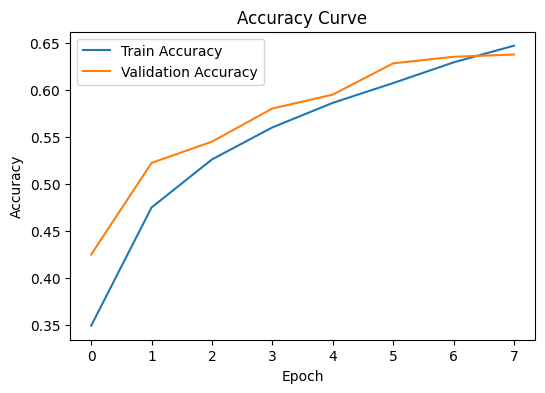

In [8]:
plt.figure(figsize=(6,4))
plt.plot(train_acc_list, label="Train Accuracy")
plt.plot(val_acc_list, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy Curve")
plt.show()


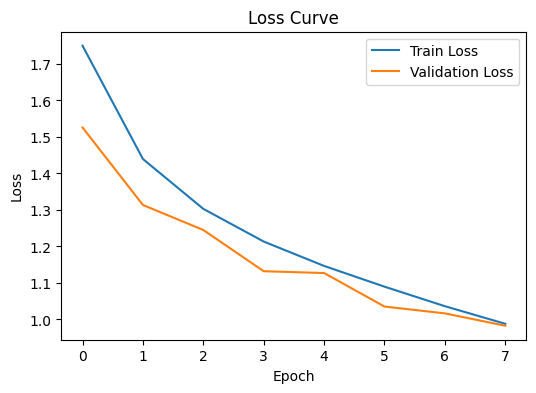

In [10]:
plt.figure(figsize=(6,4))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss Curve")
plt.show()


In [11]:
torch.save(model.state_dict(), "simple_vit_cifar10.pth")
print("Model saved!")


Model saved!


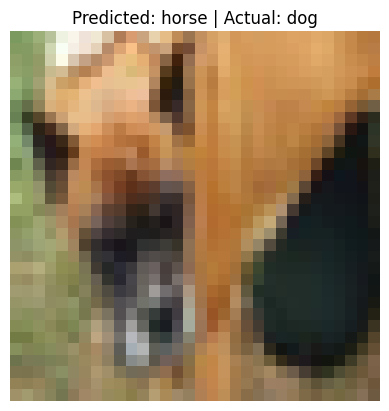

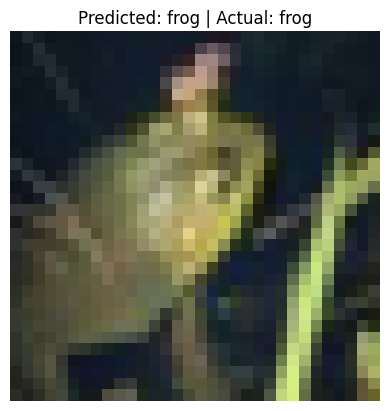

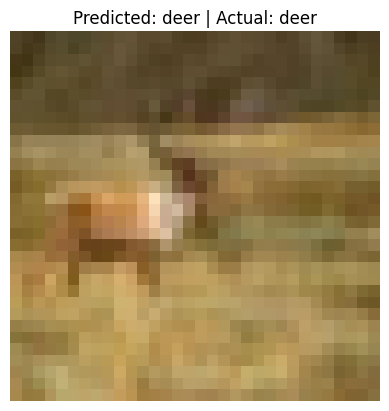

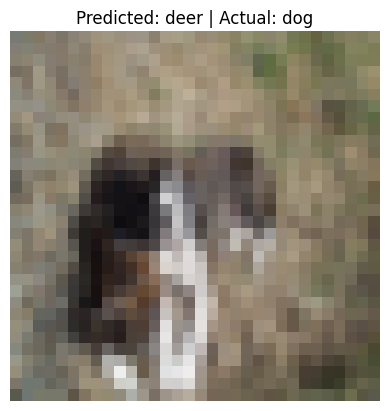

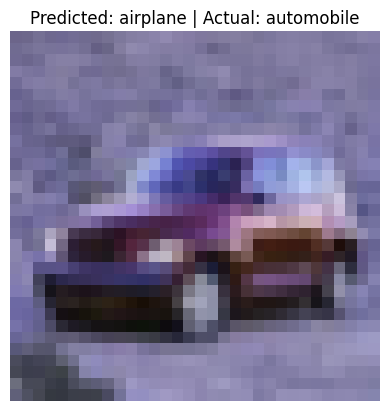

In [12]:
model.eval()

indices = random.sample(range(len(test_dataset)), 5)

for idx in indices:
    image, label = test_dataset[idx]
    img_input = image.unsqueeze(0).to(device)

    output = model(img_input)
    pred = output.argmax(1).item()

    # Unnormalize for display
    img_show = image.permute(1,2,0).numpy()
    img_show = img_show * np.array(std) + np.array(mean)
    img_show = np.clip(img_show, 0, 1)

    plt.imshow(img_show)
    plt.title(f"Predicted: {class_names[pred]} | Actual: {class_names[label]}")
    plt.axis("off")
    plt.show()
